### Shamecca Marshall
### Data 620 Project 2

### Objectives
- Identify a large 2-node network dataset. (Meet the criteria tat it consists of ties between and not within two (or more) distinct groups
- Reduce the size of the network using a method such as the island method
- What can you infer about each of the distinct groups?

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import networkx.algorithms.bipartite as bipartite
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
import powerlaw

### Research Summary
The dataset I selected was developed to support network analysis research of online communities. The findings were reported in a paper by Pietro Panzarasa and Tore Opsahl titled "Patterns and Dynamics of Users’ Behavior and Interaction". The research draws on longitudinal network data from an online community to examine patterns of users’ behavior and social interaction, to infer the dynamics of system usage.

The research includes a note of caution regarding the relationship assumptions that underpin the analysis. The dataset assumes that one message is sufficient to create a relationship. I acknowledge that this is a weak notion of a social relationship. However, this formulation enables the inclusion of all users in the analysis but might overestimate the density of the relationship structure in the graph.

I also discuss my limited ability to observe previously established offline relationships. The evolution of the network is a combination of previous offline relationships and new relationships that are developed on the platform. This analysis will likely be impacted / capture offline relationships.

And finally, the lack of message content hampers my ability to analyze and further investigate the genuine nature of the relationships identified. It would be beneficial to interrogate the substance of the messages and use that information to assess the strength of relationships.

### Data Source
The Facebook-like Forum Network was obtained from https://toreopsahl.com/datasets/#online_forum_network. This network doesn't focus on the messages exchanged between users; rather, it emphasizes the interactions between users and the topics they engage with. The network's weight can be determined by the number of messages or characters a user posts on a specific topic. I opted to utilize a static two-mode network with an edge weight based on messages. This two-mode network comprises 899 users and 522 topics.

In [55]:
# Gather network data, utilizing the number of messages as the weight factor.

# 2 mode: users and topics
weighted_2modedfdf = pd.read_csv('http://opsahl.co.uk/tnet/datasets/OF_two-mode_weightedmsg.txt',
                            sep = ' ',
                            header = None)

#set the colunmns
weighted_2modedfdf.columns = ["User", "Topic", "Weight"]

# update the user and topic to be unique
weighted_2modedfdf['User'] = 'U' + weighted_2modedfdf['User'].astype(str)
weighted_2modedfdf['Topic'] = 'T' + weighted_2modedfdf['Topic'].astype(str)

# metrics
u_df = weighted_2modedfdf.groupby('User')
u_df = u_df[['User']].agg(np.size)

t_df = weighted_2modedfdf.groupby('Topic')
t_df = t_df[['Topic']].agg(np.size)

print('The dataset has',weighted_2modedf.shape[0], 'rows and', weighted_2modedfdf.shape[1], 'columns')
print('There are',u_df.shape[0] ,'unique users in the dataset and',t_df.shape[0],'unique topics')

The dataset has 7089 rows and 3 columns
There are 899 unique users in the dataset and 522 unique topics


In [56]:
fig = px.box(weighted_2modedfdf, x="Weight", hover_data=weighted_2modedfdf.columns,
                  title="Box Plot Edge Weights")
fig.show()

In [5]:
fig = px.histogram(weighted_2modedf, x="Weight", marginal="rug",nbins=600, hover_data=weighted_2modedf.columns,
                  title="Histogram of Edge Weights")
fig.show()

###  Load Bipartite Graph

With the previously loaded dataframe, I'll construct a Bipartite graph containing both Topic and User nodes. The edge weights will represent the number of messages posted on a topic by the associated users.

In [6]:
# create the graph with the two node types
B = nx.Graph()
B.add_nodes_from(weighted_2modedf['Topic'], bipartite=0)
B.add_nodes_from(weighted_2modedf['User'], bipartite=1)

# add the weights
tuples = [tuple(x) for x in weighted_2modedf.to_numpy()]
B.add_weighted_edges_from(tuples, weight='weight')

# test to see if the graph is connected
print('We confirm that connected status of the graph. Graph connected status:',nx.is_connected(B))

# verify that a bipartite graph was created
print('We also confirmed that the the graph is a bipartite graph. Graph bipartite status:',nx.is_bipartite(B))

# create node lists for each node type
topic_nodes = {n for n, d in B.nodes(data=True) if d["bipartite"] == 0}
user_nodes = set(B) - topic_nodes

We confirm that connected status of the graph. Graph connected status: False
We also confirmed that the the graph is a bipartite graph. Graph bipartite status: True


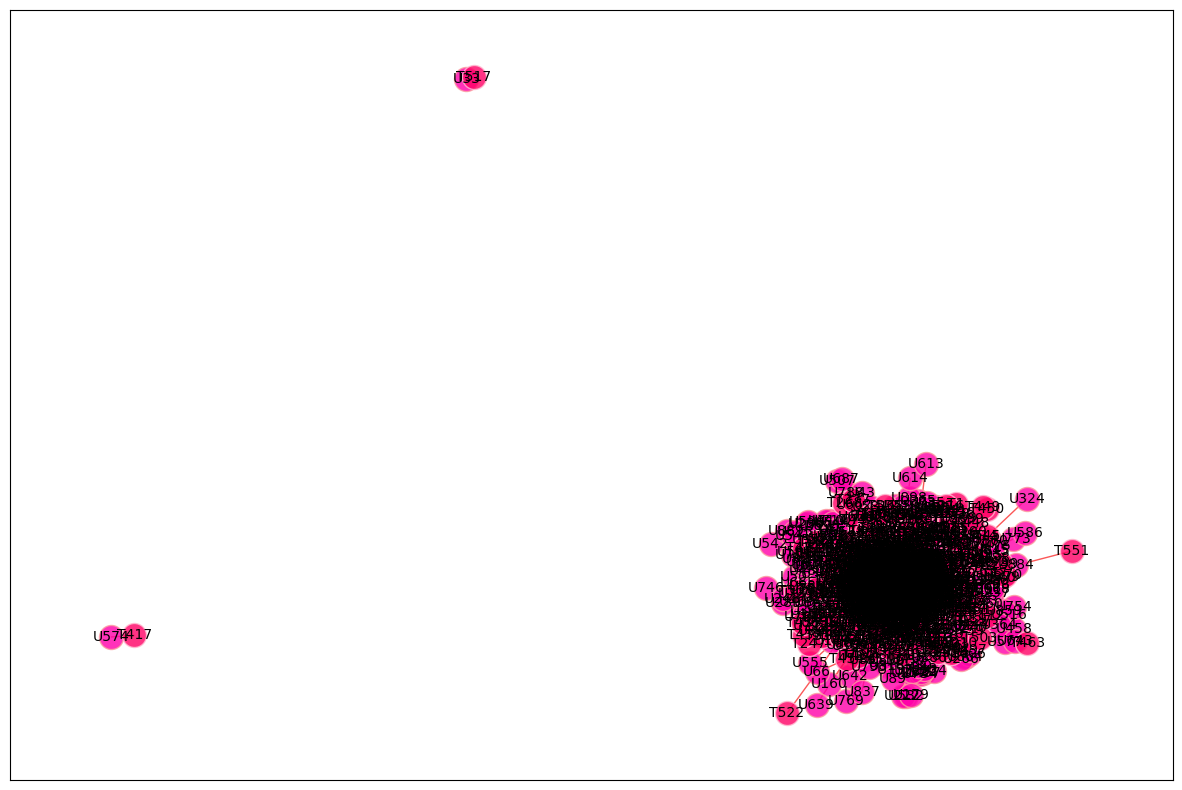

In [58]:
plt.figure(figsize = (15,10))
pos = nx.spring_layout(B)



nx.draw_networkx_nodes(B,pos,
                       nodelist=user_nodes,
                       node_color='#ff00a9',
                       edgecolors='#fb9f9f',
                       alpha=0.8)
topic = weighted_2modedf['Topic']
nx.draw_networkx_nodes(B,pos,
                       nodelist=topic_nodes,
                       node_color='#ff0065',
                       edgecolors='#ffbfd3',
                       alpha=0.8)

nx.draw_networkx_edges(B, pos,
                       edge_color='#fb5858',
                      )


dump = nx.draw_networkx_labels(B, pos, font_size=10)

The resulting graph is difficult to read however we can identify 1 large set of connected nodes and several smaller connected nodes. These Topic and User clusters depict issolated relationships between Users and Topics.

### Analyze a Filtered Graph

To isolate some of the more frequently engaged Users and Topics we used the edge weights to filter out every edge with less than 60 messages.

In [12]:
reduced_df = weighted_2modedf[weighted_2modedf['Weight'] > 60]

u_df = reduced_df.groupby('User')
u_df = u_df[['User']].agg(np.size)
#u_df.shape

t_df = reduced_df.groupby('Topic')
t_df = t_df[['Topic']].agg(np.size)
#t_df.shape

print('This results in a much smaller graph with',u_df.shape[0],'users and',t_df.shape[0],'topics.')

This results in a much smaller graph with 17 users and 11 topics.


Using the reduced dataframe to build a smaller bipartite graph. The resulting graph highlights that even in this reduced set there are still some very popular topics and prolific authors.

In [61]:
R = nx.Graph()
R.add_nodes_from(reduced_df['Topic'], bipartite=0)
R.add_nodes_from(reduced_df['User'], bipartite=1)

tuples = [tuple(x) for x in reduced_df.to_numpy()]
R.add_weighted_edges_from(tuples, weight='weight')

topic_nodes_r = {n for n, d in R.nodes(data=True) if d["bipartite"] == 0}
user_nodes_r = set(R) - topic_nodes_r

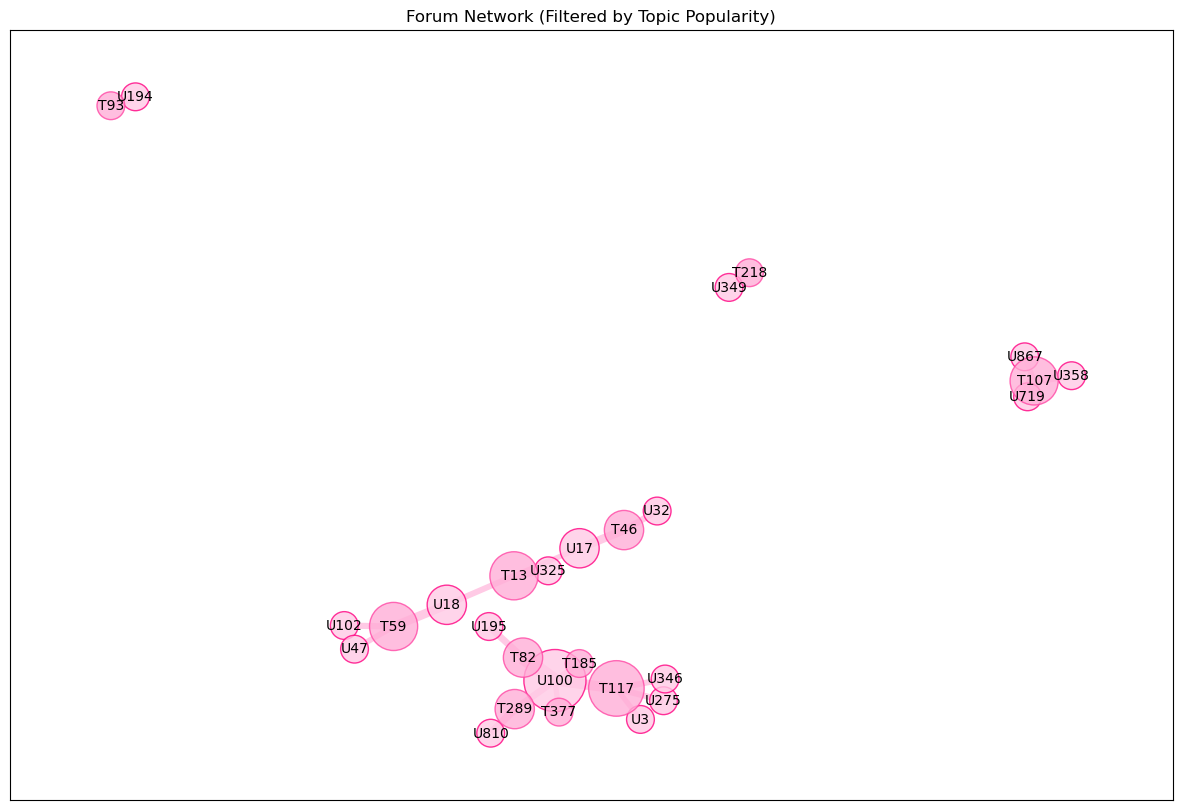

In [63]:
plt.figure(figsize = (15,10))
plt.title('Forum Network (Filtered by Topic Popularity)')

pos = nx.spring_layout(R)

edge_labels = nx.get_edge_attributes(R, 'weight')
edge_w = np.array(list(edge_labels.values())) * 0.06



userDegree_r = nx.degree(R, user_nodes_r) 
topicDegree_r = nx.degree(R, topic_nodes_r) 


nx.draw_networkx_nodes(R,pos,
                       nodelist=user_nodes_r,
                       node_color='#ffcae5',
                       node_size=[v * 400 for v in dict(userDegree_r).values()],
                       edgecolors='#ff0081',
                       
                       alpha=0.8)

nx.draw_networkx_nodes(R,pos,
                       nodelist=topic_nodes_r,
                       node_color='#ffaed7',
                       node_size=[v * 400 for v in dict(topicDegree_r).values()],
                       edgecolors='#ff48a5',
                       alpha=0.8)

nx.draw_networkx_edges(R, pos,
                       edge_color='#ffcae5',
                       width=edge_w, 
                       #edge_color=edge_w,
                       edge_cmap=mpl.cm.Greys
                      )

dump = nx.draw_networkx_labels(R, pos, font_size=10)
plt.show()

The resulting graph highlights even in this reduced set there are still some very popular topics and prolific users.

### One Mode Projection - Users

Graph Projection is utilized to analyze centrality measures for the Forum Network. I will use degree, closeness, betweenness, and eigenvector centrality measures to evaluate the relative importance of each User node in the network.

- Initially, I will project the graph onto the User node.
- I'll visualize the complete graph.
- Then, I'll compute degree, closeness, betweenness, and eigenvector centrality for the graph.
- Finally, I'll pinpoint the nodes with higher centrality measures.

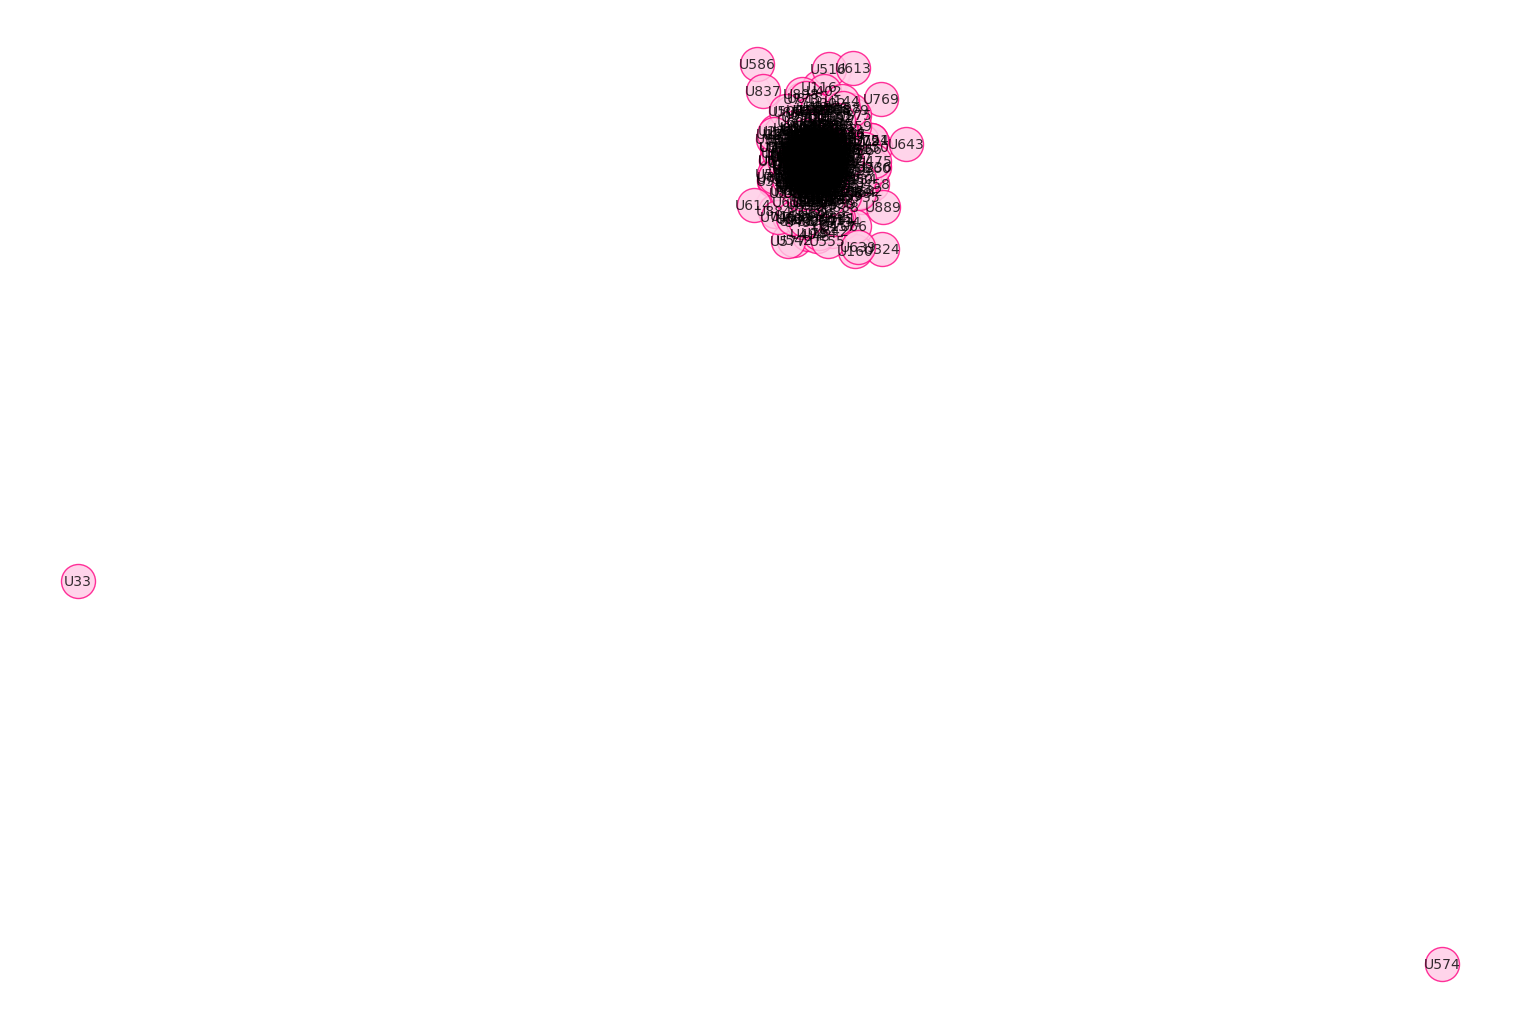

In [64]:
# User subgraph
plt.figure(figsize = (15,10))
# project graph
U = bipartite.weighted_projected_graph(B, user_nodes)

pos_U = nx.spring_layout(U)

weights_U = [edata['weight'] for f,t,edata in U.edges(data=True)]

nx.draw(U, 
        pos = pos_U, 
        with_labels=True, 
        node_color='#ffcae5',
        edgecolors='#ff0081',
        edge_color='#ffcae5',
        font_color='black', 
        node_size = 600,
        font_size=10,
        alpha=0.8)

In [20]:
# test to see if the graph is connected
print('We confirm that connected status of the graph. Graph connected status:',nx.is_connected(U))
print('The number of nodes in the projected graph:', len(U.nodes()))

We confirm that connected status of the graph. Graph connected status: False
The number of nodes in the projected graph: 899


The resulting graph projected on the User node generates a disconnected graph with a dense cluster of nodes and several single node islands.

### Measures of Centrality

In identifying the users with the highest impact on the network we used the degree, closeness, betweenness and eigenvector measures of centrality.

In [21]:
# calculate measures of centrality
deg = nx.degree(U)
c = nx.closeness_centrality(U)
b=nx.betweenness_centrality(U)
e = nx.eigenvector_centrality(U, max_iter=100) 

df = pd.DataFrame(user_nodes, columns=['User'])

df['Degree'] = df['User'].map(dict(deg))
df['Closeness'] = df['User'].map(dict(c))
df['Betweenness'] = df['User'].map(dict(b))
df['Eigenvector'] = df['User'].map(dict(e))

In [23]:
df.sort_values('Degree',ascending=False, inplace=False).round(decimals=4)

,User,Degree,Closeness,Betweenness,Eigenvector
68,U100,633,0.7714,0.0210,0.0851
341,U67,604,0.7525,0.0189,0.0817
579,U290,599,0.7494,0.0216,0.0808
834,U377,565,0.7280,0.0097,0.0808
746,U164,563,0.7274,0.0155,0.0788
...,...,...,...,...,...
192,U324,1,0.3710,0.0000,0.0002
161,U586,1,0.3733,0.0000,0.0002
826,U643,1,0.3734,0.0000,0.0002
512,U574,0,0.0000,0.0000,0.0000


Results

- Users with high centrality measures include U100, U67, U290, U377, and U164.
- Users with low centrality measures include U643, U324, U586, U574, and U33.

The scatter plot emphasizes the relationship between the 4 measures of centrality utilized in this analysis. The majority of the nodes exhibit relatively low centrality measures, but these nodes are counterbalanced by several hub nodes with notably high centrality measures. These User nodes play a crucial role in the network's connectivity and resilience.

### Scale-Free Network

The research paper concludes that this exemplifies a scale-free network. Common examples of such networks include social and computer networks. Characteristics of scale-free networks include:

- Degree following the power law: The distribution adheres to the power law, though it may deviate as the network grows.
- Preferential attachments: New nodes tend to connect with those already having high link counts.
- Hubs prevalence: Certain nodes, known as hubs, have significantly higher degrees than average.
- Network resilience: The network remains largely unaffected even when a large fraction of vertices is removed.

In evaluating if the Forum Network is a scale-free network, I examined:

- Degree distribution: Analyzed the distribution across both node types.
- Power law: Utilized a graph to assess conformity to the power law.

###  Degree Distribution
The distribution of degree measurements for both User and Topic nodes suggests that the Forum Network could be scale-free. I will utilize the box plot and standard population measures of dismemberment to assess the degree centrality measures of each node type.

In [26]:
userDegree = nx.degree(U, user_nodes) 
user_degree_df = pd.DataFrame(userDegree, columns=['User','Degree'])

fig = px.box(user_degree_df, x='Degree', title="Box Diagram of Degree Centrality (User Nodes)")
fig.show()

In [27]:
user_degree_df.describe()

,Degree
count,899.000000
mean,158.798665
std,128.461569
min,0.000000
25%,43.500000
50%,131.000000
75%,250.000000
max,633.000000


The distribution of degree centrality measures for the User node supports my assertion that the Forum Network is a scale-free network. The mean measure of degree centrality for users is 158.8, and the 75th percentile is above the mean, indicating that there is a high probability of encountering a node with a degree of centrality measure well above the mean. This observation is also evident from the box plots.

### Powers Law
In scale-free networks, the degree of centrality for nodes follows the power law. If the degree distribution conforms to the power law, I should observe a proportional change in the probability density function. This represents a functional relationship between two quantities, where a relative change in one quantity results in a proportional relative change in the other quantity, regardless of their initial size: one quantity varies as a power of another.

In [28]:
# calculate the degree distribution for the graph and fit it to the graph
degree_sequence = sorted([d for n, d in userDegree], reverse=True) # used for degree distribution and powerlaw test
fit = powerlaw.Fit(degree_sequence) 
R, p = fit.distribution_compare('power_law', 'lognormal',normalized_ratio=True)

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


In [29]:
#Calculating best minimal value for power law fit'
print('alpha:',round(fit.power_law.alpha,4))
print('sigma:',round(fit.power_law.sigma,4))
print('xmin:',round(fit.power_law.xmin,4))
print('R:',round(R,4))
print('p:',round(p,4))

alpha: 7.5536
sigma: 0.8605
xmin: 380.0
R: -0.9719
p: 0.3311


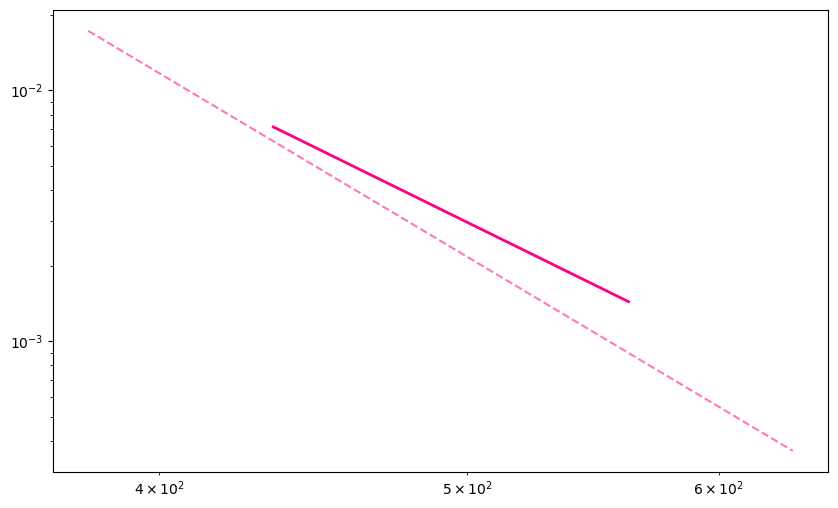

In [65]:
plt.figure(figsize=(10, 6))
fig2 = fit.plot_pdf(color='#ff0081',linewidth=2)
dump = fit.power_law.plot_pdf(color='#ff77bc', linestyle='--', ax=fig2)


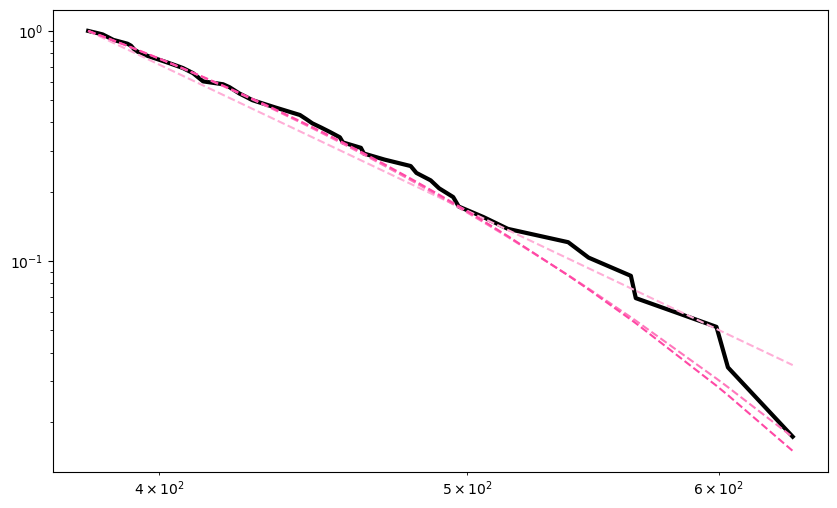

In [68]:
plt.figure(figsize=(10, 6))
fit.distribution_compare('power_law', 'lognormal', normalized_ratio=True)
fig4 = fit.plot_ccdf(linewidth=3, color='black')
fit.power_law.plot_ccdf(ax=fig4, color='#ffaed7', linestyle='--') #powerlaw
fit.lognormal.plot_ccdf(ax=fig4, color='#ff77bc', linestyle='--') #lognormal
dump = fit.stretched_exponential.plot_ccdf(ax=fig4, color='#ff48a5', linestyle='--') #stretched_exponential


The degree distribution appears to follow the powers law thus we can conclude that we are dealing with a scaled network.

### User Graph Reduction
I utilize the island method of graph reduction to identify cliques and the primary relationships between nodes. To support that analysis, I implemented 2 helper functions to trim the graph edges and control the iterations of the analysis.

In [33]:
# method to trim graph by edge weights
def trim_edges(g, weight=1):
    g2=nx.Graph()
    for f, to, edata in g.edges(data=True):
        if edata['weight'] > weight:
            g2.add_edge(f,to,**edata)
    return g2 

 
# function to find islands
def island_method(g, iterations=5):
    
    weights=[edata['weight'] for f,to,edata in g.edges(data=True)]
 
    mn=int(min(weights))
    mx=int(max(weights))

    step=int((mx-mn)/iterations)
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)] 

The graph reduction process starts with the network graph projected on the User node. We are using the default 5 iterations for the analysis.

In [34]:
# retrieve the connected graphs
S = [U.subgraph(c).copy() for c in nx.connected_components(U)][0]
islands=island_method(S)

# create dataframe for results
island_df = pd.DataFrame(columns=['threshold','nodes','islands'])

# add the results of each iteration to the dataframe
for i,r in enumerate(islands):
    island_df.loc[i] = [r[0],len(r[1]),len(list(nx.connected_components(r[1])))]
    
    
island_df  

,threshold,nodes,islands
0,1,659,1
1,7,112,1
2,13,33,3
3,19,9,1
4,25,4,1


Utilizing the Island Method, I can reduce the graph to its primary edges. By filtering the edge weights to include only those exceeding a weight of 13, I can generate a weighted graph that illustrates the network structure.

In [74]:
# variable for the target weight
filter_weight = 13        
filter_U = trim_edges(U,filter_weight)        
        
# add the edge attributes        
edge_labels = nx.get_edge_attributes(filter_U, 'weight')
edge_w = np.array(list(edge_labels.values())) * 0.3

# generate the weighted data
weights=[edata['weight'] for f,t,edata in filter_U.edges(data=True)]

# calculate the degree
userDegree = nx.degree(filter_U) 

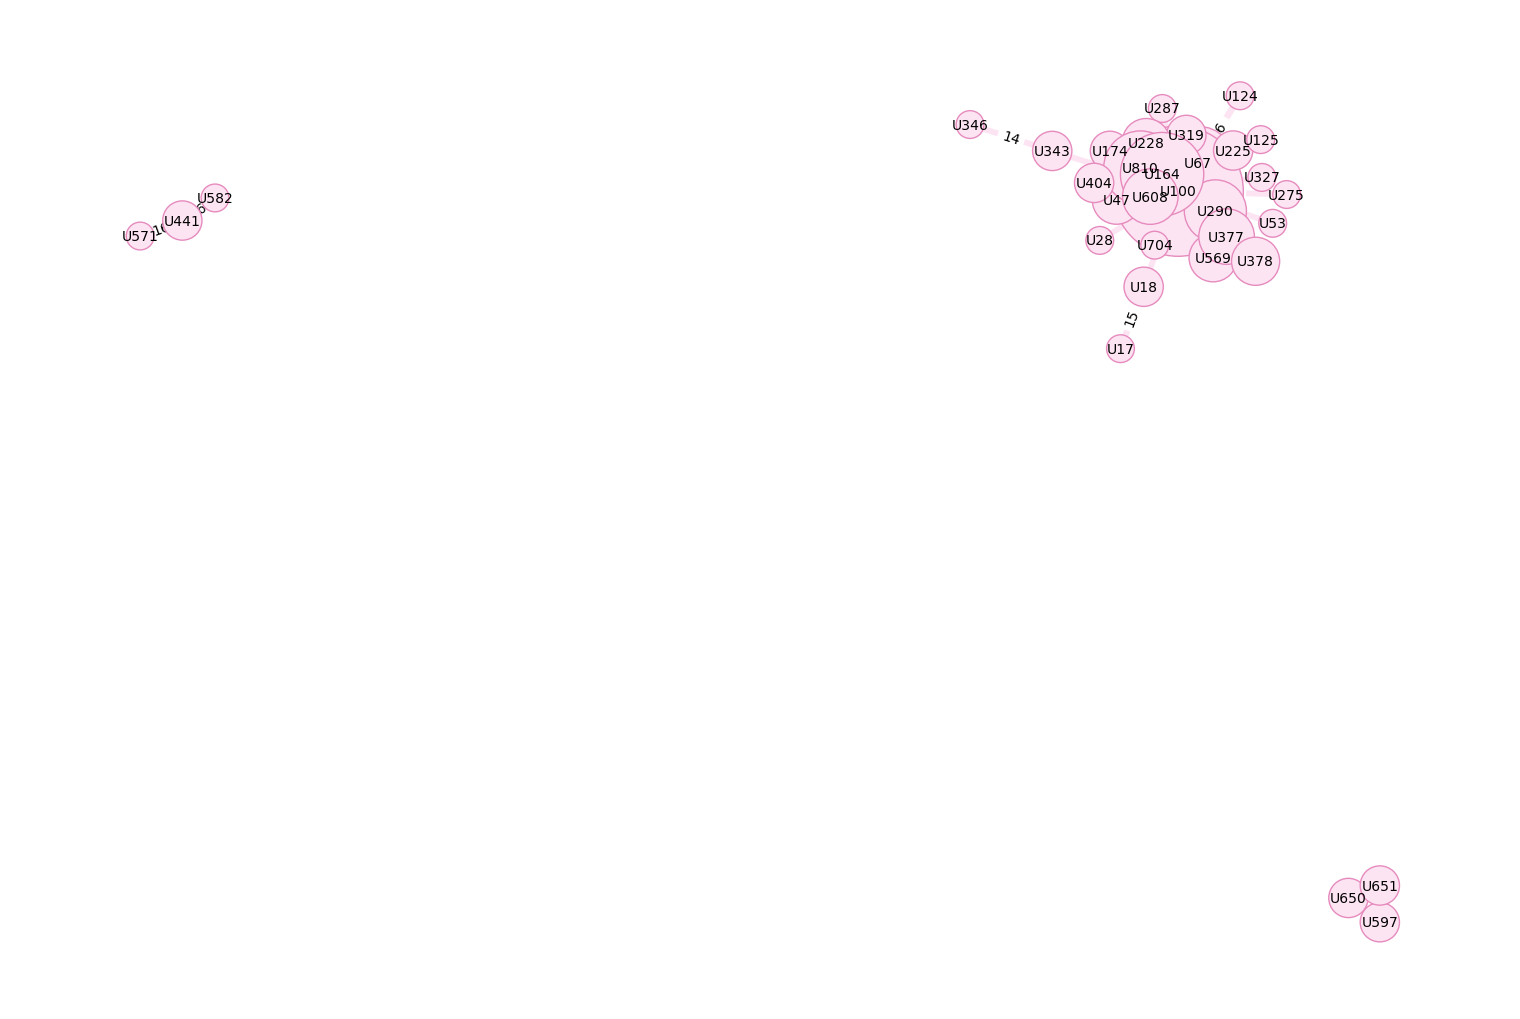

In [76]:
plt.figure(figsize = (15,10))
pos_U = nx.spring_layout(filter_U)


# plot the resulting filtered graph
nx.draw(filter_U, 
        pos=pos_U, 
        with_labels=True, 
        node_size = [v * 400 for v in dict(userDegree).values()], 
        node_color='#fde4f2', 
        edgecolors='#e68bbe',
        font_color='black', 
        font_size=10,
        edge_cmap=mpl.cm.Greys, 
        width=edge_w, 
        edge_color='#fde4f2',
        edge_vmin=0, edge_vmax=20)

dump = nx.draw_networkx_edge_labels(filter_U, pos=pos_U,edge_labels=edge_labels)

In [77]:
print('Number of User Nodes:', len(filter_U.nodes()))
print('Large Clique Size:',nx.algorithms.approximation.clique.large_clique_size(filter_U))

Number of User Nodes: 33
Large Clique Size: 5


Interestingly enough, in the reduced network graph, I observe 3 clusters of user nodes. Although within the cluster containing U100 and some of the other crucial nodes, the maximum clique size is only 5.

### Sub Graph Ego Network
To emphasize the distinction between hub nodes and the more numerous nodes with lower connectivity levels, I examined two Ego networks. The first Ego network represents a non-hub node with a lower degree of connectivity, while the second Ego network pertains to a highly connected hub node.

### U892 - Non Hub Node
I also desired to delve into the Ego Networks within the Forum Network. By concentrating on the sub-graph centered on the user node U892 as a non-hub node and U100 as a hub node, I can observe the distinctions between nodes positioned at the edges of the degree distribution. At a radius of 1, the resulting graphs exhibit notable differences. However, at a radius of 3, both Ego graphs encompass the majority of nodes in the networks. Even a node with minimal connectivity maintains a relatively short path to all nodes in the network.

In [39]:
EN = nx.ego_graph(U,'U892', radius=1)
print('The number of nodes in the network:', len(EN))
print('The average clustering for the ego network:', round(nx.average_clustering(EN),4))

The number of nodes in the network: 12
The average clustering for the ego network: 1.0


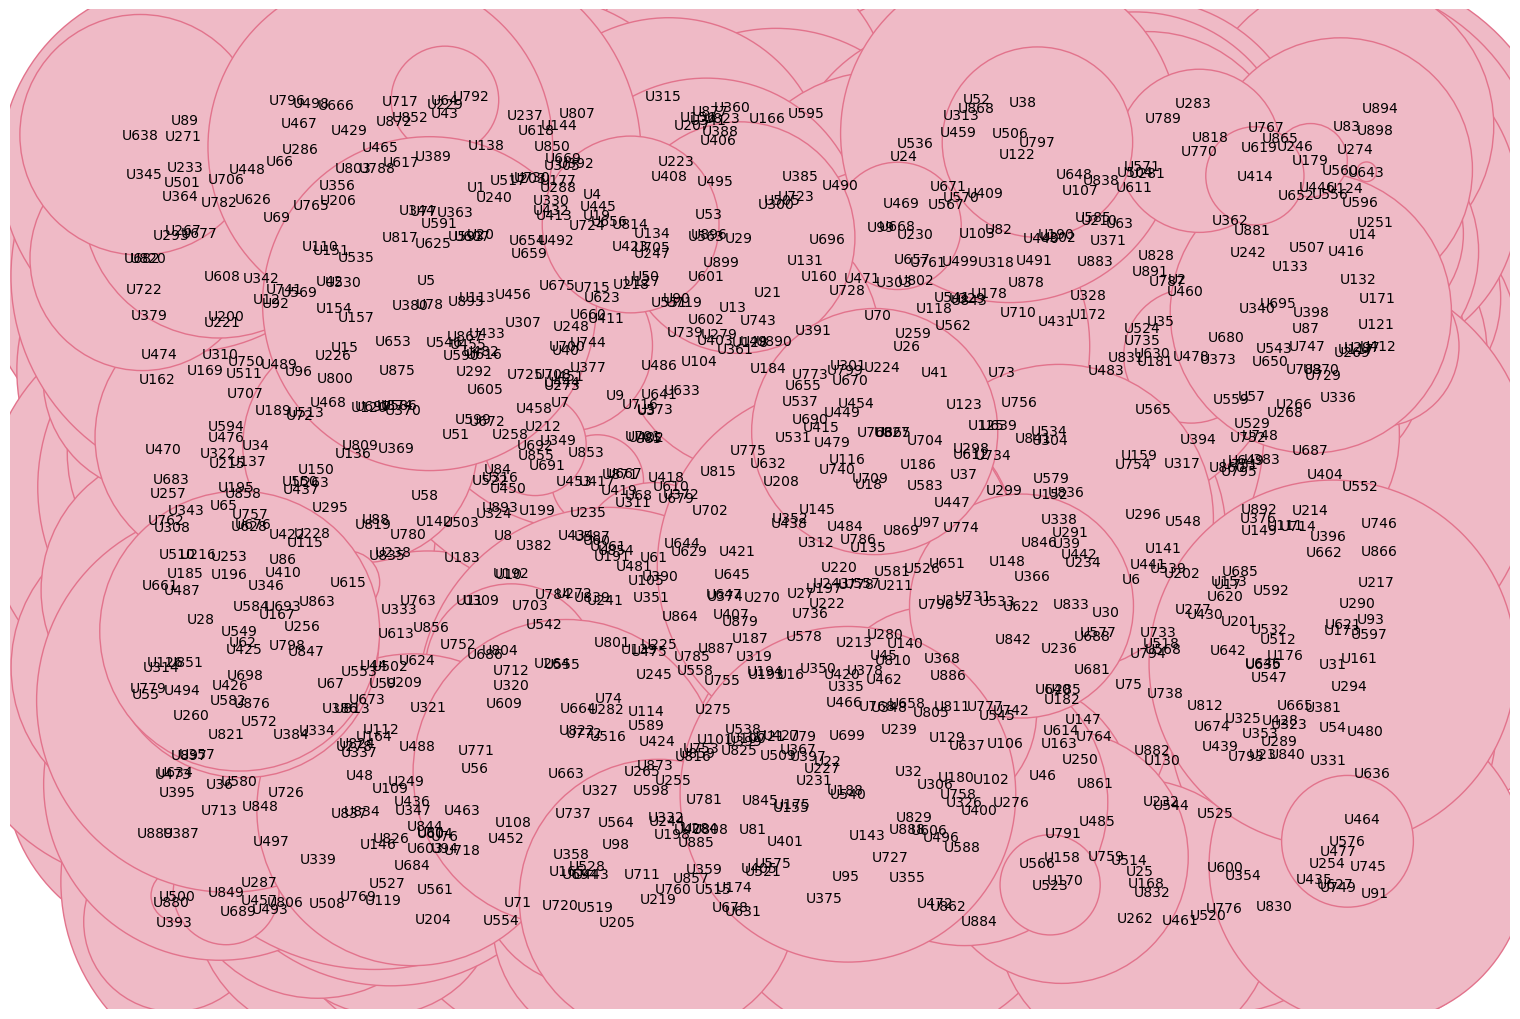

In [78]:
# config size and layout
plt.figure(figsize = (15,10))
pos = nx.random_layout(EN)

# calculate the degrees and weight for node size and edge width
userDegree = nx.degree(EN) 
edge_labels = nx.get_edge_attributes(EN, 'weight')
edge_w = np.array(list(edge_labels.values())) * 0.4

nx.draw(EN, 
        pos=pos, 
        with_labels=True, 
        node_size = [v * 200 for v in dict(userDegree).values()], 
        node_color='#efbac6', 
        edgecolors='#e2738c',
        font_color='black', 
        font_size=10,
        edge_cmap=mpl.cm.Greys, 
        width=edge_w, 
        edge_color='#efbac6',
        edge_vmin=0, edge_vmax=20)

plt.show()

In [41]:
EN = nx.ego_graph(U,'U892', radius=3)
print('The number of nodes in the network:', len(EN))
print('The average clustering for the ego network:', round(nx.average_clustering(EN),4))

The number of nodes in the network: 897
The average clustering for the ego network: 0.6962


Interestingly enough, at a radius of 3, even an ego network for a relatively isolated node like U892 experiences a substantial increase. The clustering coefficient remains high, suggesting that even at a radius of 3, the trust within the much larger network is still high.

### U100 - Hub
I also examined U100, a node with significantly higher connectivity in terms of centrality metrics. At a radius of 1, U100 demonstrates an exceptionally broad reach in disseminating information to other users. Comparatively, U100's reach surpasses that of U892 by 52.8 times at the same radius. Surprisingly, the clustering coefficient for U100's ego network is lower than that of the entire network.

In [43]:
EN2 = nx.ego_graph(U,'U100', radius=1)
print('The number of nodes in the network:', len(EN2))
print('The average clustering for the ego network:', round(nx.average_clustering(EN2),4))
print('The average clustering for the entire user network:', round(nx.average_clustering(U),4))

The number of nodes in the network: 634
The average clustering for the ego network: 0.6673
The average clustering for the entire user network: 0.6946


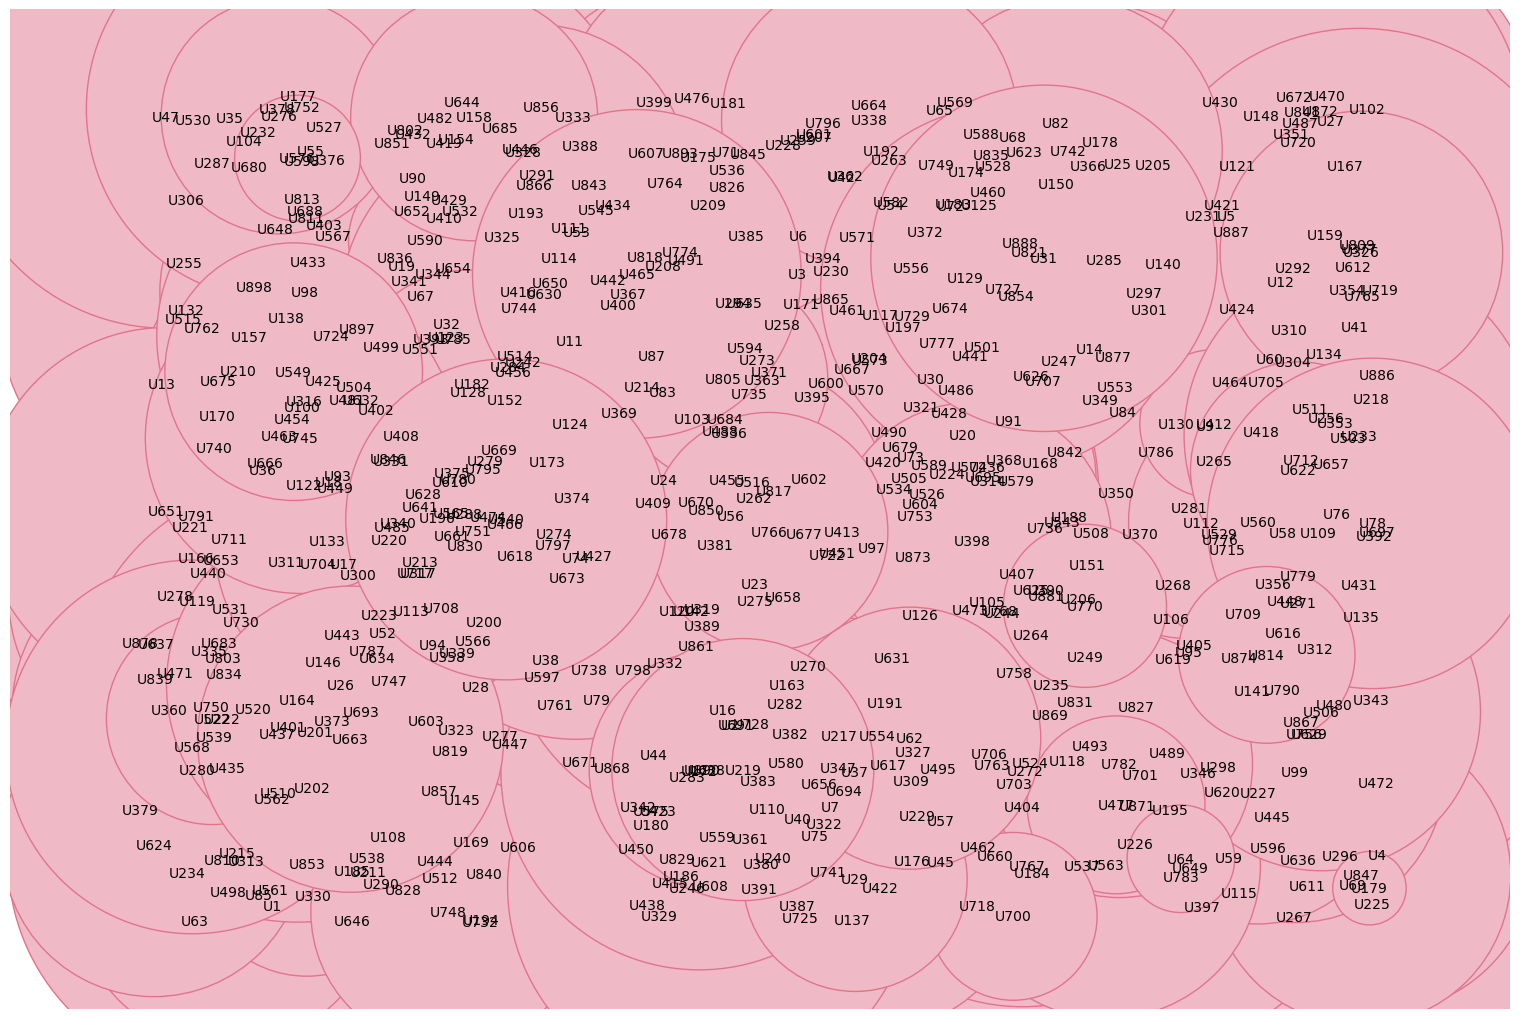

In [80]:
# config size and layout
plt.figure(figsize = (15,10))
pos = nx.random_layout(EN2)

# calculate the degrees and weight for node size and edge width
userDegree = nx.degree(EN2) 
edge_labels = nx.get_edge_attributes(EN2, 'weight')
edge_w = np.array(list(edge_labels.values())) * 0.4

nx.draw(EN2, 
        pos=pos, 
        with_labels=True, 
        node_size = [v * 200 for v in dict(userDegree).values()], 
        node_color='#efbac6', 
        edgecolors='#e2738c',
        font_color='black', 
        font_size=10,
        edge_cmap=mpl.cm.Greys, 
        width=edge_w, 
        edge_color='#efbac6',
        edge_vmin=0, edge_vmax=20)

plt.show()

Visually, it's evident that U100 has a significant reach in terms of transmission.

### One Mode Projection - Topics
Projection is employed to examine centrality metrics within the Forum Network. Degree, closeness, betweenness, and eigenvector centrality measures will be applied to evaluate the significance of each Topic node in the network.

- Initially, we'll project the graph onto the Topic node.
- We'll then compute degree, closeness, betweenness, and eigenvector centrality for the graph.
- Lastly, we'll pinpoint nodes with higher centrality metrics.

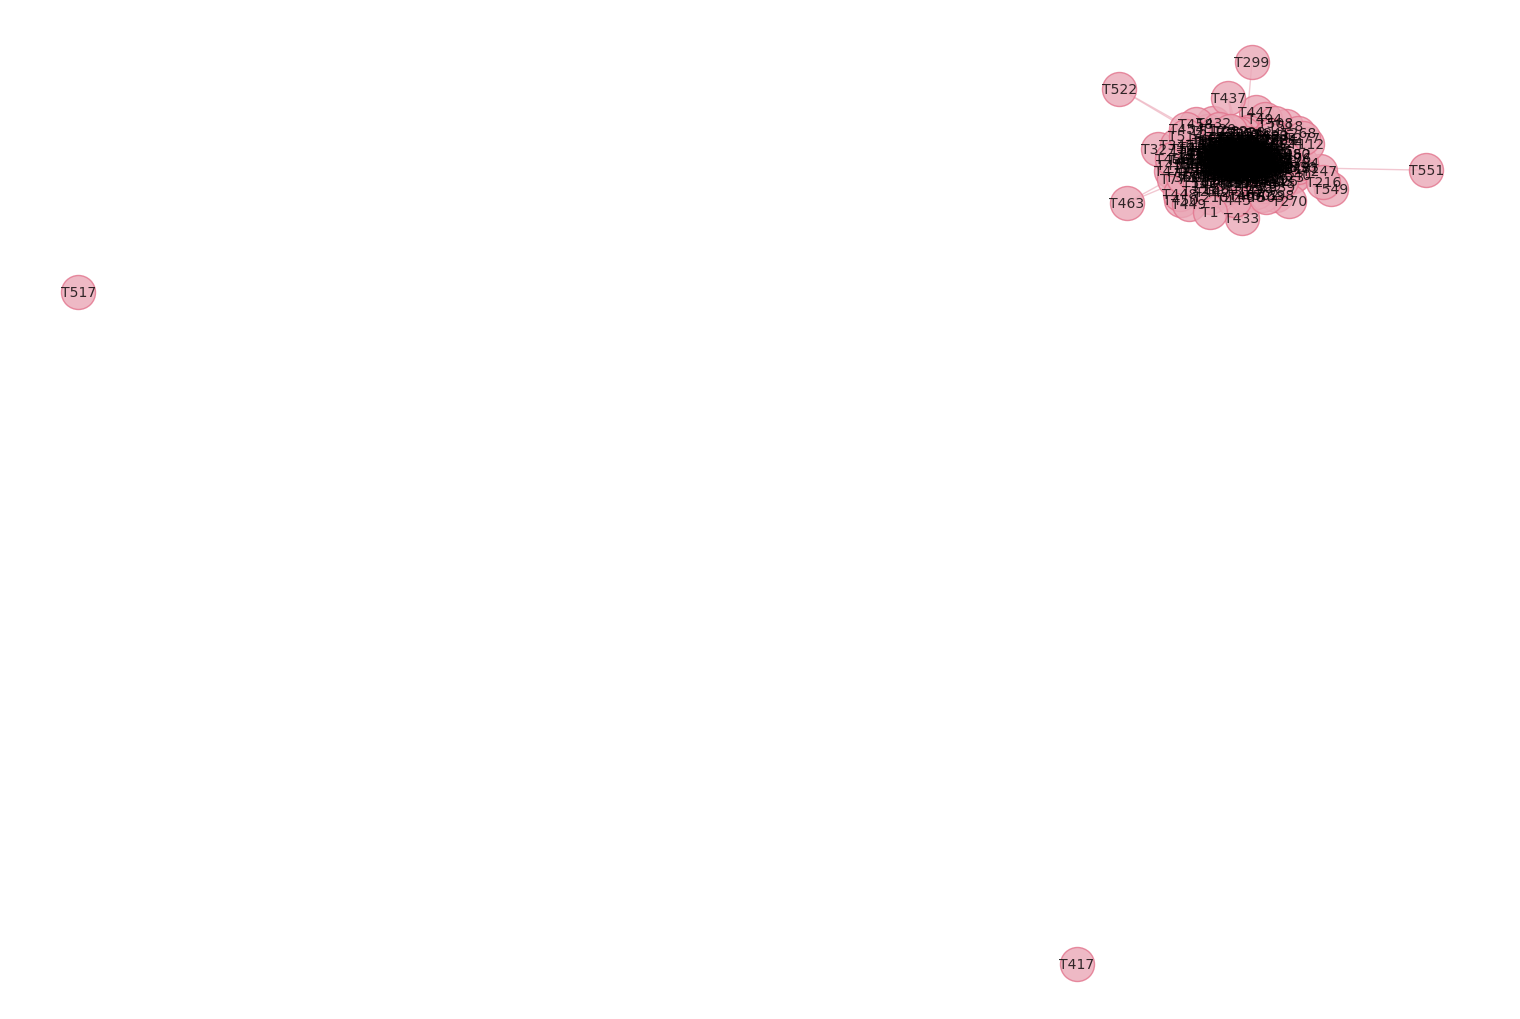

In [79]:
# topic subgraph
plt.figure(figsize = (15,10))
# project graph
T = bipartite.weighted_projected_graph(B, topic_nodes)

pos_T = nx.spring_layout(T)
weights_T = [edata['weight'] for f,t,edata in U.edges(data=True)]

nx.draw(T, pos = pos_T, 
        with_labels=True, 
        node_color='#eaa8b7',
        node_size = 600,
        font_color='black', 
        edgecolors='#e2738c',
        edge_color='#efbac6',
        font_size=10,
        alpha=0.8)

Like the User projection graph, the Topic projection nodes generate a disjointed graph comprising one major cluster of topics and two isolated single-node islands.

### Measures of Centrality
I computed the degree, closeness, betweenness, and eigenvector metrics in an attempt to delve deeper into the topics.

In [46]:
# calculate measures of centrality
deg = nx.degree(T)
c = nx.closeness_centrality(T)
b=nx.betweenness_centrality(T)
e = nx.eigenvector_centrality(T, max_iter=100) 

df = pd.DataFrame(topic_nodes, columns=['Topic'])

df['Degree'] = df['Topic'].map(dict(deg))
df['Closeness'] = df['Topic'].map(dict(c))
df['Betweenness'] = df['Topic'].map(dict(b))
df['Eigenvector'] = df['Topic'].map(dict(e))

In [47]:
df[df['Degree'] >= 0].sort_values('Degree',ascending=False, inplace=False).round(decimals=4)

,Topic,Degree,Closeness,Betweenness,Eigenvector
225,T13,410,0.8220,0.0196,0.0900
370,T12,403,0.8142,0.0158,0.0898
199,T82,397,0.8066,0.0180,0.0880
326,T237,394,0.8003,0.0111,0.0899
11,T208,390,0.7966,0.0112,0.0892
...,...,...,...,...,...
453,T463,2,0.3932,0.0000,0.0004
164,T551,1,0.3463,0.0000,0.0001
382,T299,1,0.3917,0.0000,0.0003
22,T417,0,0.0000,0.0000,0.0000


Findings:

- Noteworthy topics with elevated centrality rankings comprise T13, T12, T82, and T237.
- Conversely, topics with notably low centrality ratings encompass T417, T517, T551, and T299.

The majority of nodes exhibit relatively low centrality measures, yet these are balanced by a few prominent hub nodes boasting high centrality measures. These significant Topic nodes play a crucial role in the network's connectivity and resilience.

### Topic Graph Reduction
I will once more apply the island method to reduce the size of the topic network.

In [49]:
# retrieve the connected graphs
S2 = [T.subgraph(c).copy() for c in nx.connected_components(T)][0]
islands2=island_method(S2)

# create dataframe for results
island_df2 = pd.DataFrame(columns=['threshold','nodes','islands'])

# add the results of each iteration to the dataframe
for i,r in enumerate(islands2):
    island_df2.loc[i] = [r[0],len(r[1]),len(list(nx.connected_components(r[1])))]
    
       
island_df2

,threshold,nodes,islands
0,1,462,1
1,8,101,2
2,15,32,2
3,22,13,1
4,29,6,3
5,36,2,1


The island method has provided us with several thresholds that could effectively decrease the network size. We opted for a filter weight of 15, as it significantly reduces the node count and encompasses 2 distinct islands.

In [82]:
# variable for the target weight
filter_weight = 15       
        
filter_T = trim_edges(T,filter_weight)        
        
# add the edge attributes        
edge_labels2 = nx.get_edge_attributes(filter_T, 'weight')
edge_w = np.array(list(edge_labels2.values())) * 0.8

# generate the weighted data
weights=[edata['weight'] for f,t,edata in U.edges(data=True)]

# calculate the degree
topicDegree = nx.degree(filter_T)

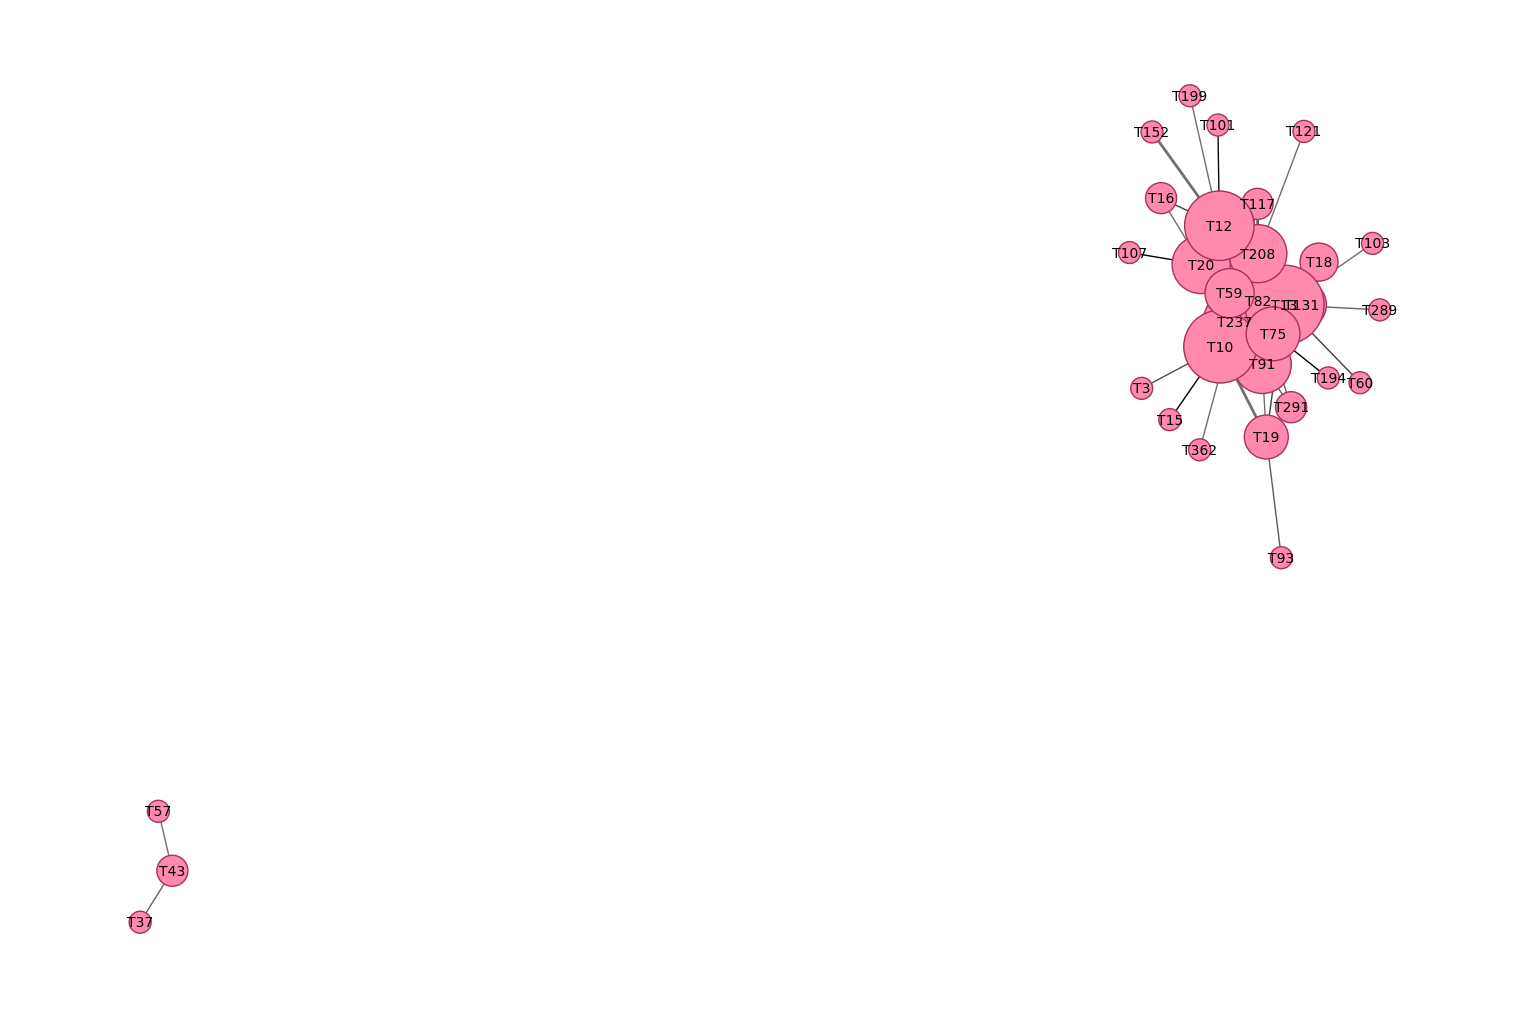

In [83]:
pos_T = nx.spring_layout(filter_T)

# plot the resulting filtered graph
plt.figure(figsize = (15,10))
nx.draw(filter_T, 
        pos=pos_T, 
        with_labels=True, 
        node_size = [v * 250 for v in dict(topicDegree).values()], 
        node_color='#ff8aad', 
        edgecolors='#a73060',
        font_color='black', 
        font_size=10,
        width=weights,
        edge_color=edge_w,
        edge_cmap=mpl.cm.Greys,
        edge_vmin=0, edge_vmax=20)

Upon reducing the network size, two distinct clusters emerged. The larger cluster encompasses several highly influential nodes in the network, such as T13, T12, T82, among others, based on centrality metrics.

### Conclusion
According to the findings of Panzarasa and Opsahl:

- The Forum Network demonstrates "scale-free" behavior.
- Users vary in popularity and sociability.
- Users tend to form strong connections and foster socially cohesive local communities.

This analysis verifies that the Forum Network indeed displays the traits of a scale-free network. The degree centrality distribution is right-skewed with a heavy tail, adhering to a power law. Consequently, the network is highly interconnected, dense, and resilient to random node removal.